<a href="https://colab.research.google.com/github/mswastik/forecasting/blob/main/SARIMAv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 9.3MB/s 
     |████████████████████████████████| 2.1MB 54.2MB/s 
     |████████████████████████████████| 8.7MB 66.3MB/s 
     |████████████████████████████████| 808kB 67.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0


In [2]:
import pmdarima as pmd
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import plotly.express as px
import cufflinks as cf
import plotly.tools as tls

In [3]:
!git clone -l -s https://github.com/mswastik/forecasting.git cloned-repo
%cd cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (39/39), done.
/content/cloned-repo


In [4]:
warnings.filterwarnings("ignore")
df = pd.read_excel('Forecasting1.xlsx',sheet_name='SO',index_col='del date')
df.rename({'agg':'agg1'},axis=1,inplace=True)
df['dd']=df.index.copy()
df['month'] = df['dd'].dt.year.astype('str')+"-"+df['dd'].dt.month.astype('str')
df2=df.groupby(['month','agg1']).sum().copy()
df2.drop(['wt','cs size'],inplace=True,axis=1)

In [24]:
toot=df.loc[df.agg1=='Tmmthpkhti Limi Yih'].copy()
toot=pd.DataFrame(toot['cases'])
toot=toot.resample('M').sum()

In [6]:
px.line(toot,y='cases',x=toot.index)

In [ ]:
px.box(toot,y='cases')

In [25]:
toot=toot.loc[toot.cases<=80000]

In [ ]:
from pmdarima.arima import ndiffs
ndiffs(toot, alpha=0.05, test='kpss', max_d=6)

1

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(toot)

Results of Dickey-Fuller Test:
Test Statistic                 -1.755483
p-value                         0.402776
#Lags Used                      6.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [8]:
toot = toot.diff(1)
toot.dropna(inplace=True)

In [28]:
toot

,cases
del date,
2012-10-31,5143.0
2012-11-30,8220.0
2012-12-31,5631.0
2013-01-31,20630.0
2013-02-28,12529.0
...,...
2020-07-31,52193.0
2020-08-31,43866.0
2020-09-30,25063.0


In [26]:
model1 = pmd.auto_arima(toot,seasonal=True,m=12)
model1

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [30]:
pred=model1.predict_in_sample(toot[0:94])

In [37]:
import plotly.graph_objects as go
fig=px.line(data_frame=toot,x=toot.index,y='cases')
fig.add_scatter(x=toot.index,y=pred,name='pred')
fig.add_scatter(x=pd.date_range(toot.index[94], periods=10,freq='M'),y=pred1,name='pred1')

In [35]:
pred1=model1.predict(10)

In [12]:
n_train = 24
n_records = len(toot)
fore = {}
res=[]
for i in range(n_train, n_records):
    pre=[]
    train, test = toot[0:i].copy(), toot[i:i+1].copy()
    mod = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 0, 0, 12))
    mod=mod.fit()
    fore.update(mod.forecast(1))
    pre = mod.forecast()
    res.extend(rmse(test,pre))
#df1.plot(legend=True,figsize=(15,10))
#pre.plot(legend=True)

In [13]:
print("Avg rmse is %d" %np.mean(res))

Avg rmse is 12991


In [16]:
mod1 = SARIMAX(toot, order=(0, 1, 1), seasonal_order=(2, 0, 0, 3))
mod1 = mod1.fit()

In [18]:
predict=mod1.get_prediction(12)
pred=predict.conf_int()
pred

,lower cases,upper cases
del date,,
2013-11-30,-44190.426570,35343.551762
2013-12-31,-37014.820467,42142.854471
2014-01-31,-37630.434059,41217.754926
2014-02-28,-39426.864793,39162.532923
2014-03-31,-41542.946418,36827.033017
...,...,...
2020-07-31,-50982.086899,25366.755939
2020-08-31,-36568.760639,39778.403034
2020-09-30,-37472.154512,38873.405084


In [20]:
import plotly.graph_objects as go
fig=px.line(data_frame=toot,x=toot.index,y='cases',labels="Actual")
fig.add_scatter(x=pred.index,y=pred['lower cases'])
fig.add_scatter(x=pred.index,y=pred['upper cases'],fill='tonexty')
fig.add_scatter(x=toot.index,y=toot['cases'])
#fig2=px.area(cint)
#fig.add_trace()

In [ ]:
fig2=px.area(cint,x=cint.index,y='lower y')
fig2.add_scatter(x=cint.index,y=cint['upper y'])

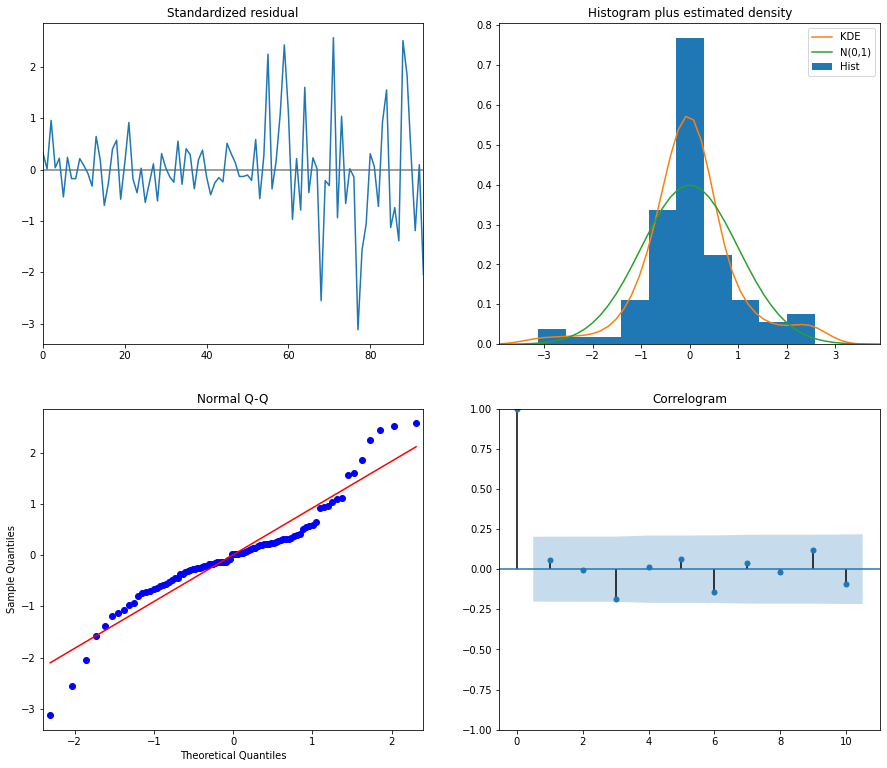

In [ ]:
kk=mod1.plot_diagnostics()
kk.set_size_inches(15,13)
#tls.mpl_to_plotly(kk)

In [ ]:
mod.get_forecast(6).conf_int()

,lower cases,upper cases
93,-15699.988162,41292.435638
94,-46756.966589,16665.465272
95,-29071.925267,34350.506594
96,-33558.716445,32006.382284
97,-21968.040161,44097.556789
98,-33953.215027,32112.381924


In [ ]:
ff = pd.DataFrame.from_dict(data=fore,orient='index',columns=["pred"])
#pre1 = inv_boxcox(mod.get_forecast(6).predicted_mean,fitted_lambda)-1
#pre1=pd.DataFrame(pre1)
#pre1.rename(columns={0:"pred"},inplace=True)
#ff=ff.append(pre1)

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
df3,fitted_lambda= boxcox(df1['Qty']+1,lmbda=None)

NameError: ignored

In [ ]:
def evaluate_arima_model(X, arima_order,s_order):
    splits = TimeSeriesSplit(n_splits=3)
    error=[]
    # make predictions
    for train_index, test_index in splits.split(X):
        train = X.values[train_index]
        test = X.values[test_index]
        model = SARIMAX(train, order=arima_order,seasonal_order=s_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        error.append(rmse(test.T[0], yhat))
    return np.asarray(error).mean()
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, m):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in p_values:
                    for D in d_values:
                        for Q in q_values:
                            order = (p,d,q)
                            s_order = (P,D,Q,m)
                            try:
                                mse = evaluate_arima_model(dataset, order,s_order)
                                if mse < best_score:
                                    best_score, best_cfg = mse, (order,s_order)
                                print('SARIMA%sx%s RMSE=%.3f' % (order,s_order,mse))
                            except:
                                continue
    print('Best SARIMA %s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [0,1,2,3,4]
d_values = range(0, 2)
q_values = range(0, 4)
evaluate_models(df1, p_values, d_values, q_values,12)

SARIMA(0, 0, 0)x(0, 0, 0, 12) RMSE=1716.003
SARIMA(0, 0, 0)x(0, 0, 1, 12) RMSE=1554.912
SARIMA(0, 0, 0)x(0, 0, 2, 12) RMSE=1437.645
SARIMA(0, 0, 0)x(0, 0, 3, 12) RMSE=1374.687
SARIMA(0, 0, 0)x(0, 1, 0, 12) RMSE=1177.831
SARIMA(0, 0, 0)x(0, 1, 1, 12) RMSE=1152.103
SARIMA(0, 0, 0)x(0, 1, 2, 12) RMSE=1182.464
SARIMA(0, 0, 0)x(0, 1, 3, 12) RMSE=1179.829
SARIMA(0, 0, 0)x(1, 0, 0, 12) RMSE=1241.914
SARIMA(0, 0, 0)x(1, 0, 1, 12) RMSE=1274.391
SARIMA(0, 0, 0)x(1, 0, 2, 12) RMSE=1312.642
SARIMA(0, 0, 0)x(1, 0, 3, 12) RMSE=1308.297
SARIMA(0, 0, 0)x(1, 1, 0, 12) RMSE=1181.554
SARIMA(0, 0, 0)x(1, 1, 1, 12) RMSE=1197.323
SARIMA(0, 0, 0)x(1, 1, 2, 12) RMSE=1199.893
SARIMA(0, 0, 0)x(1, 1, 3, 12) RMSE=1179.862
SARIMA(0, 0, 0)x(2, 0, 0, 12) RMSE=1341.675
SARIMA(0, 0, 0)x(2, 0, 1, 12) RMSE=1317.626
SARIMA(0, 0, 0)x(2, 0, 2, 12) RMSE=1327.595
SARIMA(0, 0, 0)x(2, 0, 3, 12) RMSE=1325.177
SARIMA(0, 0, 0)x(2, 1, 0, 12) RMSE=1192.402
SARIMA(0, 0, 0)x(2, 1, 1, 12) RMSE=1184.396
SARIMA(0, 0, 0)x(2, 1, 2, 12) RM

In [ ]:
ndiffs(df1, alpha=0.05, test='adf', max_d=6)

1

In [ ]:
adf_test(df2.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.621722e+00
p-value                        6.013716e-09
#Lags Used                     4.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
Critical Value (10%)          -2.585038e+00
dtype: float64


In [ ]:
#plt.figure(figsize=(15,10))
#from plotly.plotly import plot_mpl
hh=seasonal_decompose(x=toot,model='additive').plot()
hh.set_size_inches(15,13)
tls.mpl_to_plotly(hh)

ValueError: ignored

In [ ]:
cf.set_config_file(offline_show_link=False)